The objective of this project is to determine the optimal chess opening strategy. While the winning percentage of an opening is a crucial factor, it is not the sole criterion that should guide our decision-making process. It is imperative to consider the frequency of occurrence of a particular opening, as the rarity of an opening may render its high winning percentage irrelevant. Therefore, it is crucial to identify popular and widely played openings to determine the best strategy for success.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


In [2]:
df = pd.read_csv(r"C:\Users\PC\Desktop\Springboard Data Science Career Track\Springboard - github\DataScience Capstone 2\Capstone 2 - Adding Moves df", index_col=[0])   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44332657 entries, 0 to 44332656
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Event             object
 1   White Elo         int64 
 2   Black Elo         int64 
 3   Result            object
 4   Termination       object
 5   Time Control      object
 6   Opening           object
 7   Game URL          object
 8   White First Move  object
 9   Black First Move  object
dtypes: int64(2), object(8)
memory usage: 3.6+ GB


There is an excessive amount of distinct openings when accounting for variations. To tackle this, we'll start by categorizing the data according to the primary openings and their respective variations. We will keep variations as it is information we might want to look at later on. 

In [4]:
df[["Opening", "Opening Variation"]] = df["Opening"].str.split(":", expand=True)

Next, we will be splitting the data for time control and increment. 

In [5]:
df[["Time Control", "Time Control: Increment"]] = df["Time Control"].str.split("+", expand=True)

Modifying the Result column to denote "White Won" and using numerical notation (1, 0, 0.5) instead of the traditional notation (1-0, 0-1, 1/2-1/2) can offer significant benefits in data analysis and processing.

In [6]:
# Changing the Result column to White Won, 1 (won), 0 (lost), and .5 (draw).
df["White Won"] = df["Result"].str.replace(re.escape('1-0'), '1') \
                                                .str.replace(re.escape('0-1'), '0') \
                                                .str.replace(re.escape('1/2-1/2'), '.5') 
# Making sure White Won is a float.
df['White Won'] = df['White Won'].astype(float)

C:\Users\PC\AppData\Local\Temp\ipykernel_3196\3508185966.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["White Won"] = df["Result"].str.replace(re.escape('1-0'), '1') \


In [7]:
# Adding another column, Elo Difference. 
df['Elo Difference'] = df['White Elo'] - df['Black Elo']
df['Elo Difference Absolute'] = abs(df['White Elo'] - df['Black Elo'])


In [8]:
# Reorganizing columns. 
df = df[['Event', 'Opening', 'Opening Variation', 'White Elo', 'Black Elo', 'Elo Difference', 'Elo Difference Absolute', 'White Won', 'Termination', 'Time Control', 'Time Control: Increment', "White First Move", "Black First Move", "Game URL"]]      

In [9]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,White Elo,Black Elo,Elo Difference,Elo Difference Absolute,White Won
count,44332657.00,44332657.00,44332657.00,44332657.00,44332657.00
mean,1654.47,1654.45,0.02,59.54,0.52
std,368.97,368.98,114.03,97.26,0.49
min,600.00,600.00,-2000.00,0.00,0.00
25%,1396.00,1395.00,-30.00,12.00,0.00
50%,1674.00,1674.00,0.00,30.00,0.50
75%,1922.00,1922.00,30.00,66.00,1.00
max,3526.00,3553.00,2026.00,2026.00,1.00


This table represents summary statistics for the dataset. 

Here is what the columns mean:

White Elo: The Elo rating of the white player in each game.
Black Elo: The Elo rating of the black player in each game.
Elo Difference: The difference in Elo rating between the white and black players in each game.
White Won: A variable indicating whether the white player won the game (1), lost the game (0), or tied the game (.5).

Here is details about the rows:
The "count" row shows that there are 44,332,657 games in the dataset.

The "mean" row shows that White Elo and Black Elo ratings are very similar (around 1654), with a mean difference of only 0.02. The mean White Won rate is 0.52, indicating that white wins slightly more often than black in this dataset.

The "std" row shows the standard deviation of each column. The Elo Difference column has a large standard deviation of 114.03, indicating that the Elo rating difference between players varies widely across games.

The "min" and "max" row show the minimum Elo Difference is -2000 and the maximum Elo Difference is 2026. This indicates that in at least one game the black player had a rating 2000 points higher than the white player and at least one game the white plater had a rating 2026 points higher than the black player. Furthermore, it shows that the minimum Elo in the dataset is 600 and the max is 3526 for white and 3553 for black.

The "25%", "50%", and "75%" rows show the 25th, 50th (median), and 75th percentiles for each column, respectively. Notably, 25% of games have an Elo Difference of -30 or lower, and 75% of games have an Elo Difference of 30 or higher. The medium rating is 1674.00

Per information from https://www.318chess.com/elo.html, if there is a rating difference of 100 between two players, the higher-rated player has a 64.01% chance of winning. To focus on games that I consider "fair," we will only consider matches where the Elo difference between the opponents is between -100 and 100, and exclude those where the difference is greater than 100 or less than -100.

In [10]:
df = df[(df['Elo Difference'] >= -100) & (df['Elo Difference'] <= 100)]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37988224 entries, 0 to 44332655
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Event                    object 
 1   Opening                  object 
 2   Opening Variation        object 
 3   White Elo                int64  
 4   Black Elo                int64  
 5   Elo Difference           int64  
 6   Elo Difference Absolute  int64  
 7   White Won                float64
 8   Termination              object 
 9   Time Control             object 
 10  Time Control: Increment  object 
 11  White First Move         object 
 12  Black First Move         object 
 13  Game URL                 object 
dtypes: float64(1), int64(4), object(9)
memory usage: 4.2+ GB


Count the number of games in each opening and prepare to only work with the most popular openings. 

In [12]:
df['Opening'].value_counts()

Sicilian Defense        4438293
Queen's Pawn Game       3194990
French Defense          2221699
Scandinavian Defense    1955913
Caro-Kann Defense       1780550
                         ...   
Amar Gambit                  22
Formation                    20
Venezolana Opening           16
Veresov Opening              14
Dresden Opening               8
Name: Opening, Length: 157, dtype: int64

In [13]:
df['Opening'].value_counts(normalize=True).cumsum().head(55)

Sicilian Defense           0.116833
Queen's Pawn Game          0.200938
French Defense             0.259422
Scandinavian Defense       0.310909
Caro-Kann Defense          0.357780
Italian Game               0.400196
King's Pawn Game           0.435518
Queen's Gambit Declined    0.466242
English Opening            0.496838
Modern Defense             0.524937
Philidor Defense           0.551329
Ruy Lopez                  0.574632
Indian Defense             0.596355
Bishop's Opening           0.616535
Scotch Game                0.636285
Zukertort Opening          0.655387
Russian Game               0.673623
Pirc Defense               0.691094
Van't Kruijs Opening       0.705214
Vienna Game                0.718913
Four Knights Game          0.732406
Horwitz Defense            0.745882
Hungarian Opening          0.757521
Owen Defense               0.769129
Nimzo-Larsen Attack        0.780169
Slav Defense               0.791144
Benoni Defense             0.801931
Nimzowitsch Defense        0

In [14]:
# Mostly an arbitrary decision, but we will be Looking to keep roughly top 95% of openings played.
# We will achieve this through the heads() method.
mask = df["Opening"].isin(df["Opening"].value_counts(normalize=True).cumsum().head(55).index)
df = df[mask]

In [15]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,White Elo,Black Elo,Elo Difference,Elo Difference Absolute,White Won
count,36220161.00,36220161.00,36220161.00,36220161.00,36220161.00
mean,1643.68,1643.72,-0.04,30.96,0.52
std,354.09,354.11,40.10,25.48,0.49
min,600.00,600.00,-100.00,0.00,0.00
25%,1394.00,1394.00,-24.00,10.00,0.00
50%,1661.00,1661.00,0.00,24.00,0.50
75%,1901.00,1901.00,24.00,47.00,1.00
max,3070.00,3069.00,100.00,100.00,1.00


In [16]:
df['White Won'].value_counts()

1.0    17998966
0.0    16662141
0.5     1559054
Name: White Won, dtype: int64

Calculate win percentage by opening

In [17]:
openings = df.groupby(['Opening'])
win_percentages = openings['White Won'].mean() * 100
print("Win percentage by Opening:\n", win_percentages)

Win percentage by Opening:
 Opening
Alekhine Defense           50.583262
Benoni Defense             50.724268
Bird Opening               51.659853
Bishop's Opening           53.270371
Blackmar-Diemer Gambit     52.894967
Caro-Kann Defense          50.307574
Center Game                52.206266
Dutch Defense              52.069783
Elephant Gambit            49.277486
English Defense            51.832981
English Opening            52.729235
Englund Gambit             50.298291
Englund Gambit Complex     50.401446
Englund Gambit Declined    50.912106
Four Knights Game          51.870891
French Defense             50.602489
Giuoco Piano               49.020499
Grob Opening               51.280917
Horwitz Defense            52.843669
Hungarian Opening          51.510282
Indian Defense             51.784786
Italian Game               52.732839
King's Gambit Accepted     53.534109
King's Gambit Declined     51.105081
King's Indian Attack       53.277502
King's Indian Defense      51.226116
Ki

In [18]:
win_percentages_sorted = win_percentages.sort_values(ascending=False)
win_percentages_sorted.head(20)

Opening
Queen's Gambit Accepted    55.331861
Scotch Game                54.500363
Polish Opening             53.824055
Vienna Game                53.727916
King's Gambit Accepted     53.534109
Queen's Gambit Declined    53.384954
King's Indian Attack       53.277502
Bishop's Opening           53.270371
Semi-Slav Defense          53.231410
Queen's Pawn Game          52.944876
Blackmar-Diemer Gambit     52.894967
Horwitz Defense            52.843669
Ruy Lopez                  52.832226
King's Knight Opening      52.807430
Slav Defense               52.770489
Italian Game               52.732839
English Opening            52.729235
Philidor Defense           52.572707
Center Game                52.206266
Nimzo-Indian Defense       52.202019
Name: White Won, dtype: float64

Overall win percentage for white: 51.845415596026754


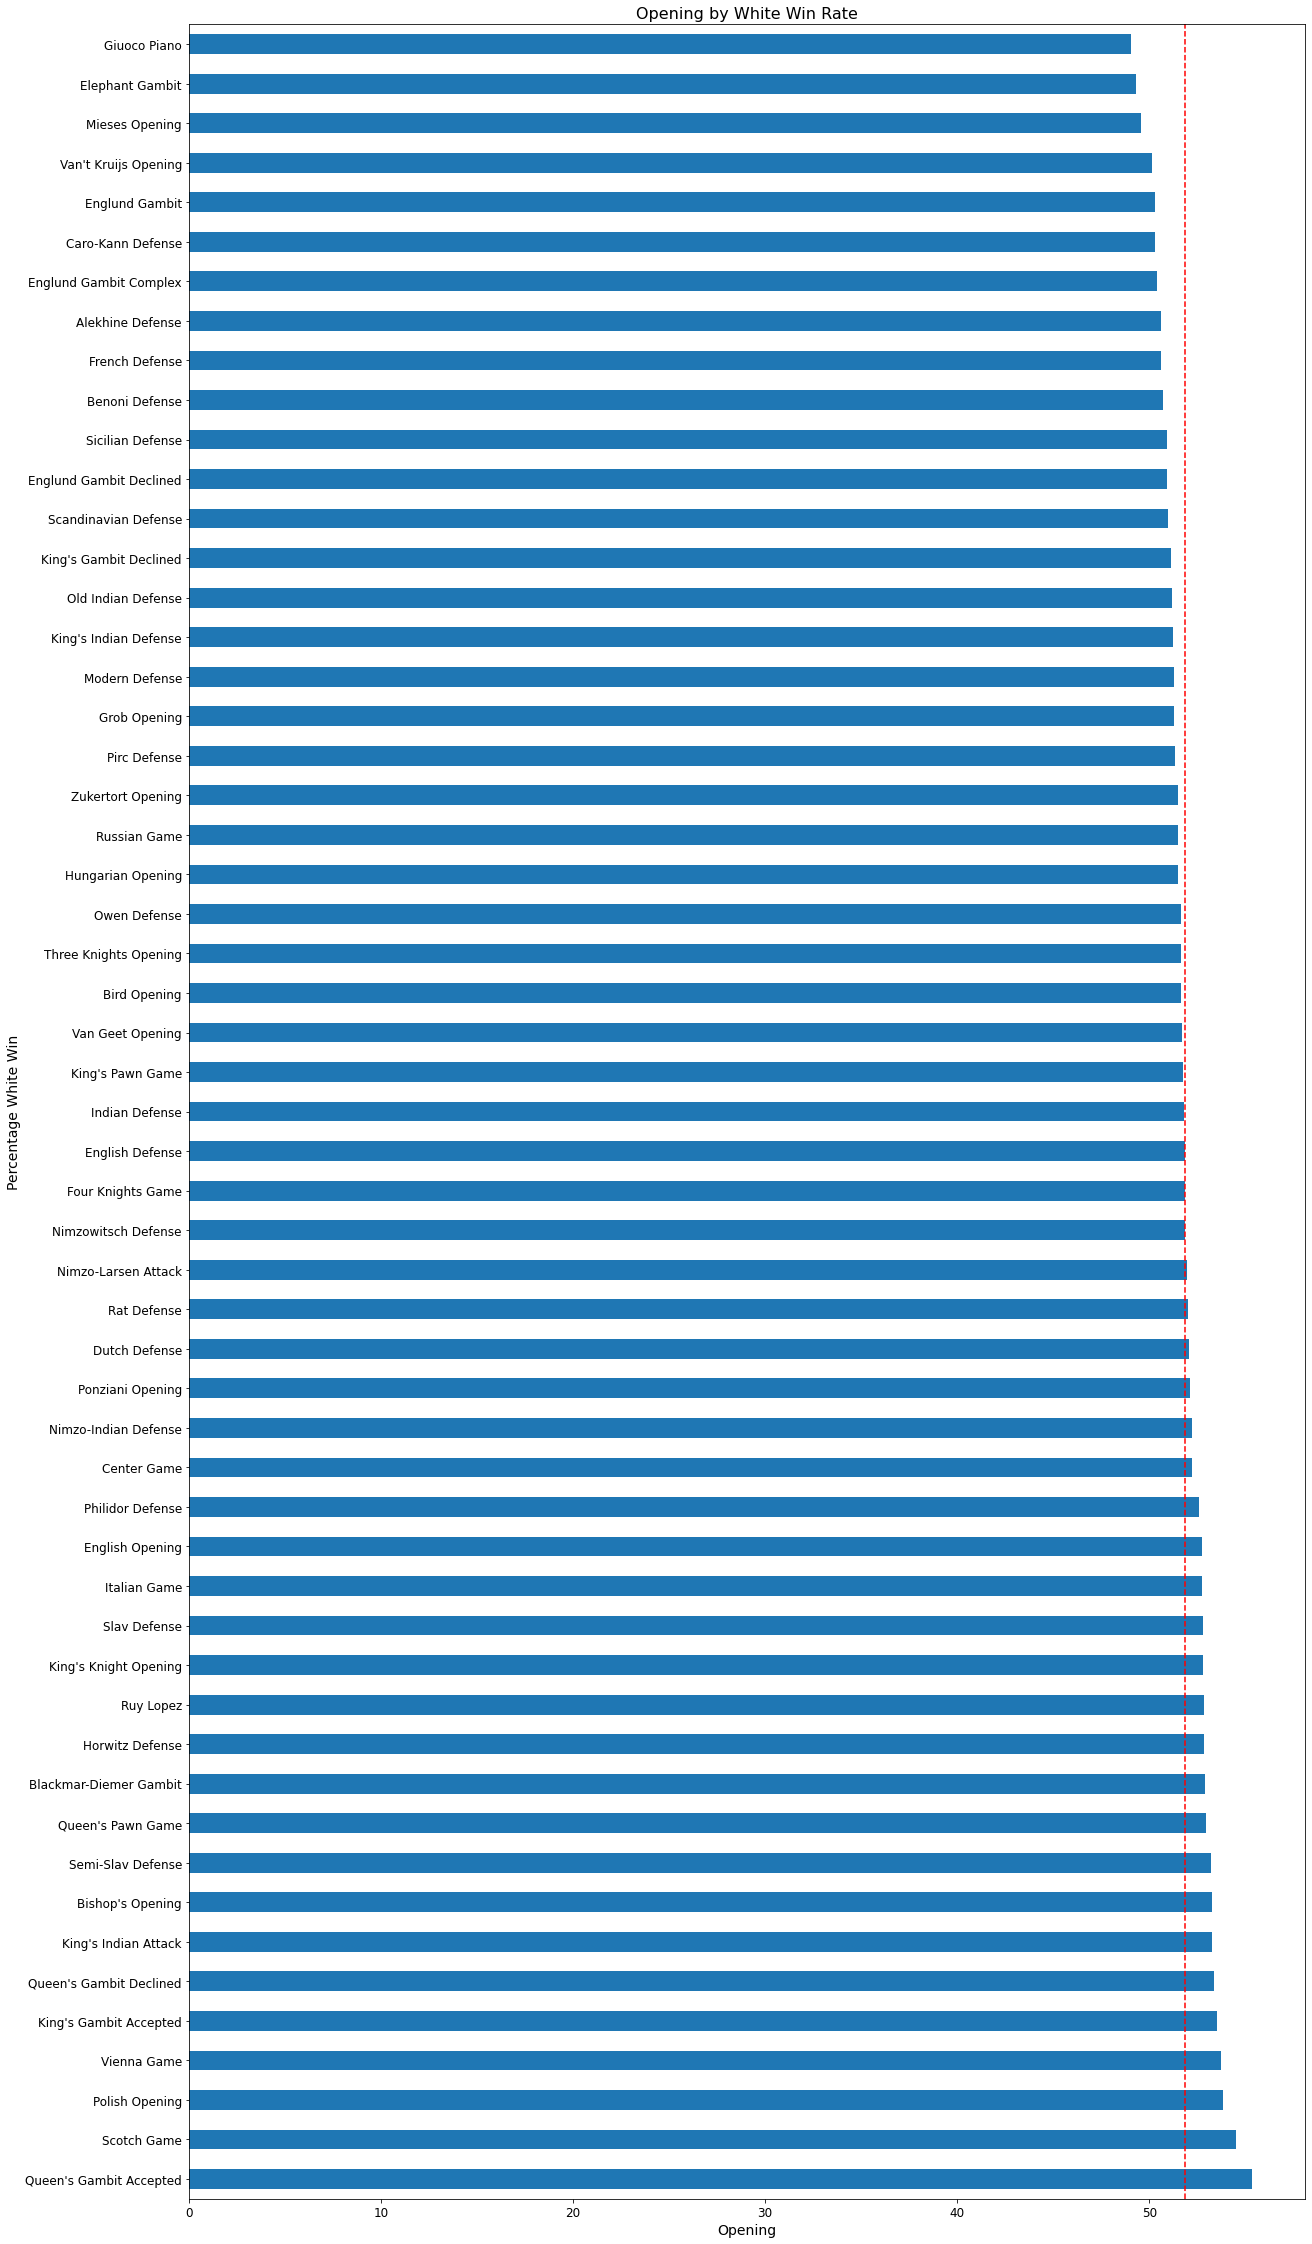

In [19]:
# Calculate overall win percentage for white
overall_win_percentage = df['White Won'].mean() * 100
print("Overall win percentage for white:", overall_win_percentage)

# Create a bar plot of win percentages sorted by opening
ax = win_percentages_sorted.plot(kind='barh', figsize=(20, 40))

# Add a horizontal line for the overall win percentage
plt.axvline(x=overall_win_percentage, color='r', linestyle='--')

# Set the x and y ticks font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the y-axis label
plt.ylabel("Percentage White Win", fontsize=14)
plt.xlabel("Opening", fontsize=14)

# Set the title
plt.title("Opening by White Win Rate", fontsize=16)

# Show the plot
plt.show()

Create a heatmap showing most successful openings. 

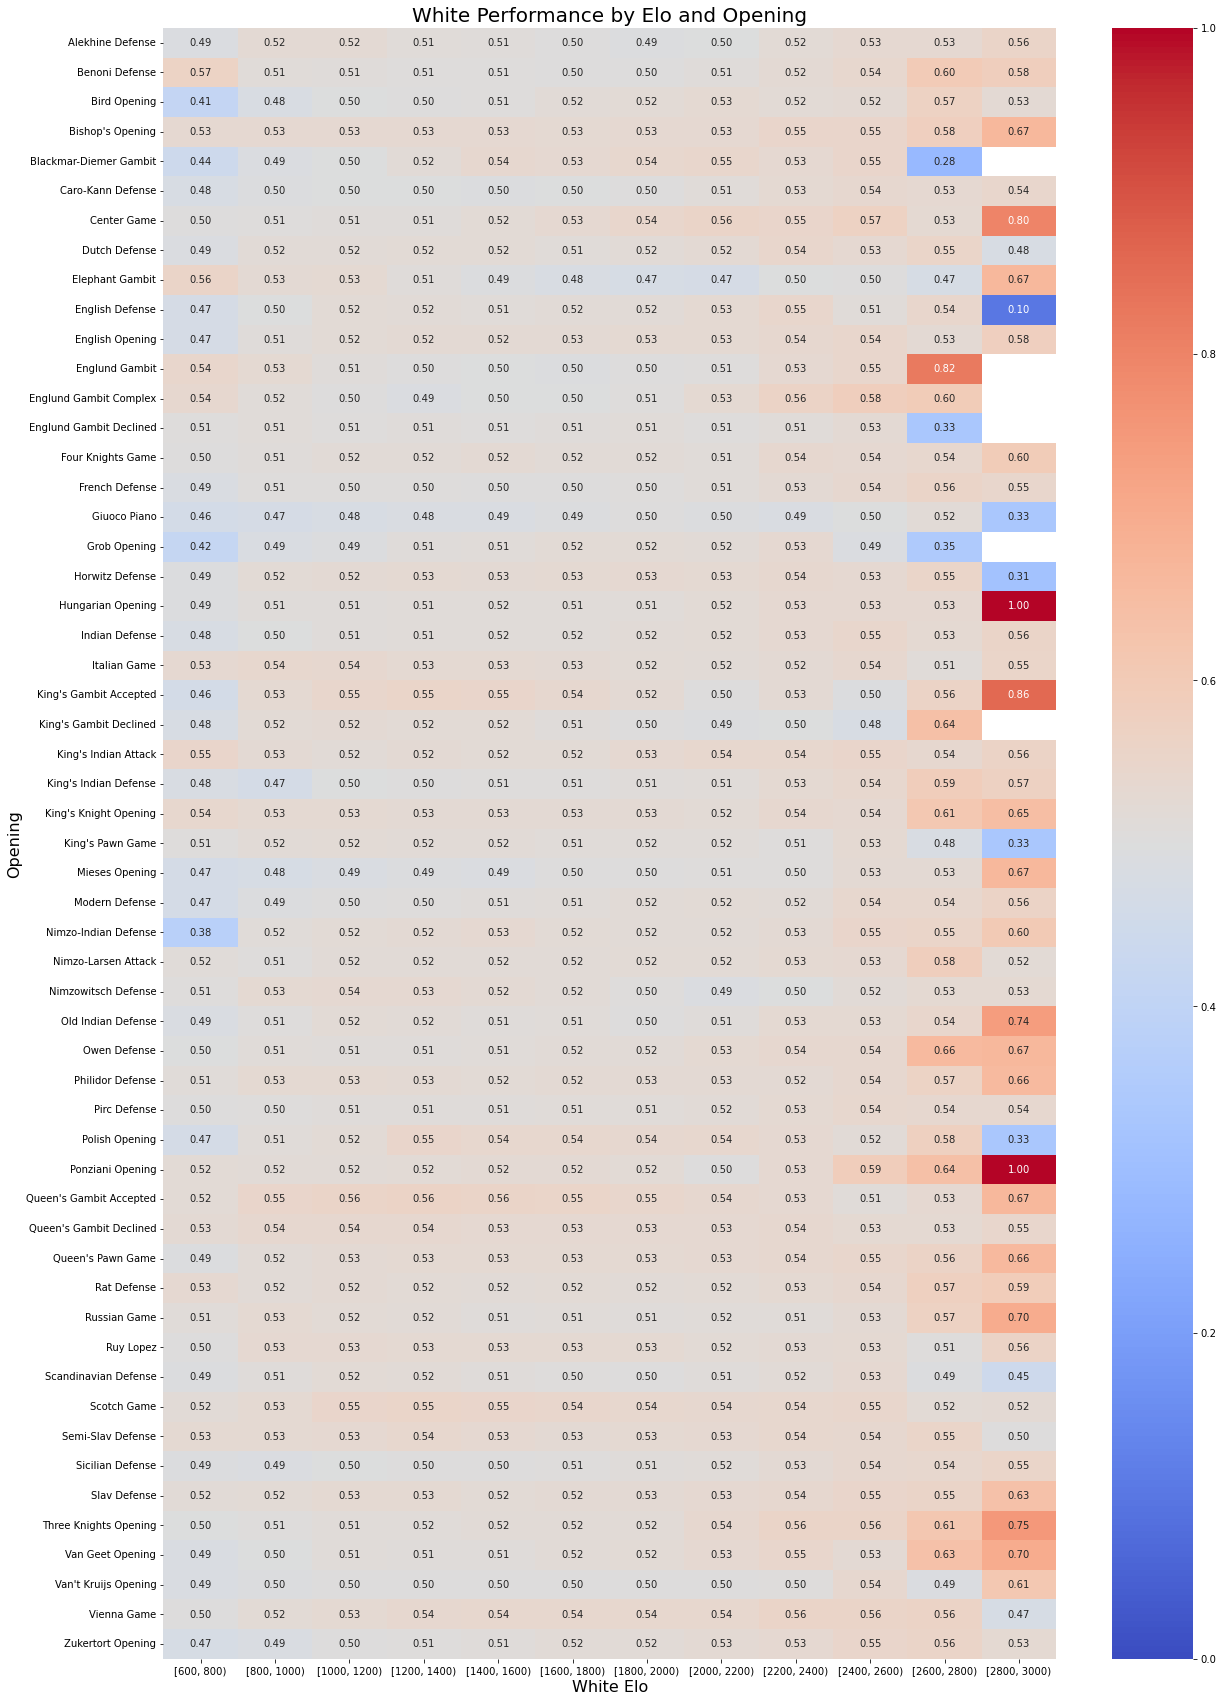

In [20]:
# Create bins for White Elo
elo_bins = range(600, 3200, 200)

# Group the data by White Elo and Opening and calculate the mean of White Won
grouped_data = df.groupby([pd.cut(df['White Elo'], elo_bins, right=False), 'Opening'])['White Won'].mean().reset_index()

# Pivot the data to create a heatmap
heatmap_data = grouped_data.pivot(index='Opening', columns='White Elo', values='White Won')

# Set the size of the heatmap
plt.figure(figsize=(20, 30))

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f', vmin=0.0, vmax=1.0)

# Add a title
plt.title('White Performance by Elo and Opening', fontsize=20)

# Set x-axis and y-axis labels
plt.xlabel('White Elo', fontsize=16)
plt.ylabel('Opening', fontsize=16)

# Show the plot
plt.show()

Let's put the above heatmap into words. 

In [21]:
# Iterate over the rating bins
for rating_bin in heatmap_data.columns[0:]:
    # Find the maximum win percentage for the current rating bin
    max_win_percentage = heatmap_data.loc[:, rating_bin].max()
    # Find the opening(s) with the maximum win percentage
    best_openings = heatmap_data.loc[:, rating_bin][heatmap_data.loc[:, rating_bin] == max_win_percentage].index.tolist()
    # Print the results
    print(f"For rating between {str(rating_bin)}, the opening(s) with the highest win percentage are: {', '.join(best_openings)} (win percentage = {max_win_percentage*100:.2f})")


For rating between [600, 800), the opening(s) with the highest win percentage are: Benoni Defense (win percentage = 56.64)
For rating between [800, 1000), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 54.77)
For rating between [1000, 1200), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 55.77)
For rating between [1200, 1400), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 56.22)
For rating between [1400, 1600), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 55.82)
For rating between [1600, 1800), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 55.33)
For rating between [1800, 2000), the opening(s) with the highest win percentage are: Queen's Gambit Accepted (win percentage = 54.66)
For rating between [2000, 2200), the opening(s) with the highest win perce

Creating a new dataframe with the most successful openings in order to better display the results. 

In [22]:
df_filtered = df[(df['Opening'] == 'Ponziani Opening') & (df['White Elo'] >= 2800) \
                | (df['Opening'] == 'Hungarian Opening') & (df['White Elo'] >= 2800) \
                | (df['Opening'] == 'Englund Gambit') & df['White Elo'].between(2600, 2799) \
                | (df['Opening'] == 'Ponziani Opening') & df['White Elo'].between(2400, 2599) \
                 | (df['Opening'] == 'Englund Gambit') & df['White Elo'].between(2200, 2399) \
                | (df['Opening'] == 'Center Game') & df['White Elo'].between(2000, 2199) \
                | (df['Opening'] == "Queen's Gambit Accepted") & df['White Elo'].between(800, 1999) \
                | (df['Opening'] == 'Benoni Defense') & df['White Elo'].between(600, 799)]

df_filtered

,Event,Opening,Opening Variation,White Elo,Black Elo,Elo Difference,Elo Difference Absolute,White Won,Termination,Time Control,Time Control: Increment,White First Move,Black First Move,Game URL
135,Rated Blitz game,Queen's Gambit Accepted,Old Variation,1247,1233,14,14,1.0,Time forfeit,180,0,d4,d5,https://lichess.org/dv5GR0cC
194,Rated Blitz game,Queen's Gambit Accepted,Old Variation,1769,1775,-6,6,1.0,Normal,300,0,d4,d5,https://lichess.org/fpnUzyQo
304,Rated Blitz tournament,Queen's Gambit Accepted,Rosenthal Variation,1986,1980,6,6,1.0,Time forfeit,180,0,d4,d5,https://lichess.org/zNCJPx47
384,Rated Blitz game,Queen's Gambit Accepted,None,1609,1708,-99,99,1.0,Normal,300,0,d4,d5,https://lichess.org/c1GNKtEa
397,Rated Blitz tournament,Queen's Gambit Accepted,None,1891,1896,-5,5,0.0,Time forfeit,180,0,d4,d5,https://lichess.org/F58DrQDk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44332105,Rated Blitz game,Queen's Gambit Accepted,Rosenthal Variation,1643,1625,18,18,0.0,Normal,300,0,d4,d5,https://lichess.org/p9DWK75v
44332331,Rated Blitz game,Queen's Gambit Accepted,None,1066,1072,-6,6,0.0,Normal,300,3,d4,d5,https://lichess.org/xIaGBLhl
44332405,Rated Blitz game,Queen's Gambit Accepted,"Central Variation, Greco Variation",1743,1720,23,23,1.0,Normal,180,0,d4,d5,https://lichess.org/PbRUpseE
44332458,Rated Blitz game,Queen's Gambit Accepted,Old Variation,1432,1434,-2,2,0.0,Normal,180,0,d4,d5,https://lichess.org/wMyDM3Es


In [23]:
# create a new column called "White Elo Bin"
df_filtered['White Elo Bin'] = pd.cut(df_filtered['White Elo'], bins=elo_bins, right=False)

# group the data by White Elo bin, Opening categories, and calculate the average "White Won" percentage
win_percentages = df_filtered.groupby(['White Elo Bin', 'Opening'])['White Won'].mean() * 100

# format the win percentages with two decimal places and a percentage sign
win_percentages = win_percentages.map('{:.2f}%'.format)

# group the data by White Elo bin and Opening categories and count the occurrences
counts = df_filtered.groupby(['White Elo Bin', 'Opening']).size().rename('Count')

# filter out rows with a count of zero
counts = counts[counts > 0]

# merge the counts and win percentages DataFrames on the 'White Elo Bin' and 'Opening' columns
result = pd.merge(counts.reset_index(), win_percentages.reset_index(), on=['White Elo Bin', 'Opening'])

# print the resulting DataFrame
print(result)


C:\Users\PC\AppData\Local\Temp\ipykernel_3196\2295850574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['White Elo Bin'] = pd.cut(df_filtered['White Elo'], bins=elo_bins, right=False)


   White Elo Bin                  Opening  Count White Won
0     [600, 800)           Benoni Defense    565    56.64%
1    [800, 1000)  Queen's Gambit Accepted  11273    54.77%
2   [1000, 1200)  Queen's Gambit Accepted  39198    55.77%
3   [1200, 1400)  Queen's Gambit Accepted  67066    56.22%
4   [1400, 1600)  Queen's Gambit Accepted  86178    55.82%
5   [1600, 1800)  Queen's Gambit Accepted  84841    55.33%
6   [1800, 2000)  Queen's Gambit Accepted  58930    54.66%
7   [2000, 2200)              Center Game  12360    55.81%
8   [2200, 2400)           Englund Gambit   2245    53.23%
9   [2400, 2600)         Ponziani Opening    296    58.78%
10  [2600, 2800)           Englund Gambit     42    82.14%
11  [2800, 3000)        Hungarian Opening      6   100.00%
12  [2800, 3000)         Ponziani Opening      1   100.00%


Let's visualize Elo distribution for white. 

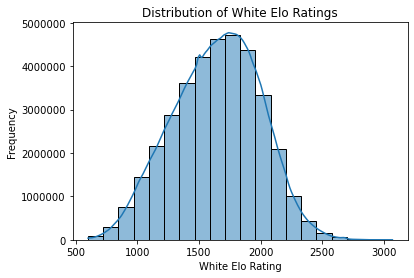

In [24]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="White Elo", bins=20, kde=True, ax=ax)
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('White Elo Rating')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of White Elo Ratings')
plt.show()

# Conclusion

The data provides valuable insights into the chess playing habits of individuals across different Elo bins. Elo rating is a metric used to measure the relative skill levels of chess players, and it's noteworthy that the majority of players have an Elo rating around 1654. This should also suggests that a majority of games would be played within this Elo bin. 

When it comes to choosing an opening strategy as White, the data indicates that the Queen's Gambit Accepted is one of the most popular and successful opening for White across all Elo bins. However, it's important to note that the success rate of this opening does vary across different Elo bins. For example, players in the 600 - 800 Elo bin have a success rate of 56.73% with the Benoni Defense opening, while players in the 2800 - 3000 Elo bin have a success rate of 100% with the Hungarian Opening.

Moreover, the data also shows that the sample sizes for some of the popular openings in higher Elo bins, such as the Hungarian Opening, the Center Game and the Englund Gambit, are relatively small. As a result, the success rates for these openings appear to be highly skewed, and may not necessarily reflect the actual performance of these openings.

In light of this data, it is recommended that players take into consideration their own Elo rating and the success rates of different openings when choosing their opening strategy in chess. By doing so, they can optimize their chances of success and tailor their playing style to their level of skill. Overall, the data serves as a useful tool for chess players looking to enhance their game and reach their full potential.

In [27]:
# Saving df to use for ML
df.to_csv('df_EDA_result.csv', index=False)